In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [60]:
sourceFile = open("gpu_logs/porto_last2hours.txt", 'w')

### Load the data

In [40]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [41]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [42]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [48]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)))

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [49]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [50]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [51]:
number_of_timesteps = 8

In [52]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 8/8 [00:00<00:00, 36.80it/s]


,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
0,2019-01-01 02:00:00,1,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-01 02:15:00,1,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-01 02:30:00,1,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961
3,2019-01-01 02:45:00,1,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538
4,2019-01-01 03:00:00,1,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...
1756395,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286
1756396,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398
1756397,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887
1756398,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528


In [53]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,DayOfWeek,Weekend,Hour
0,2019-01-01 02:00:00,1,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,1,0,2
1,2019-01-01 02:15:00,1,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,1,0,2
2,2019-01-01 02:30:00,1,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,1,0,2
3,2019-01-01 02:45:00,1,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,1,0,2
4,2019-01-01 03:00:00,1,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756395,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,2,0,22
1756396,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,2,0,23
1756397,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,2,0,23
1756398,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,2,0,23


In [54]:
df_new.to_csv("data/porto_last2hours.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [55]:
df_test = pd.read_csv("data/porto_last2hours.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/porto_last2hours.csv", engine='c', dtype=float32_cols)
df

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,DayOfWeek,Weekend,Hour
0,2019-01-01 02:00:00,1,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,1,0,2
1,2019-01-01 02:15:00,1,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,1,0,2
2,2019-01-01 02:30:00,1,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,1,0,2
3,2019-01-01 02:45:00,1,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,1,0,2
4,2019-01-01 03:00:00,1,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756395,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,2,0,22
1756396,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,2,0,23
1756397,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,2,0,23
1756398,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,2,0,23


In [56]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([29, 12, 11, 42,  3, 28, 39, 32, 23,  5]),
 array([ 7, 49, 12,  5, 13, 32,  8, 26, 42, 19]),
 array([45, 50, 37, 24, 49, 23, 34,  1, 18, 46]),
 array([29, 47,  8, 42, 37, 30, 22, 49, 20,  9]),
 array([ 4, 35, 26, 37, 21, 24, 36, 22, 41, 40]),
 array([13, 15,  5,  9, 46,  2, 26, 25, 48, 24]),
 array([ 9,  6, 33, 27, 20,  3, 17, 41, 30, 38]),
 array([12, 17, 10, 32, 28, 21, 27, 11, 18, 46]),
 array([50, 17, 42, 36, 45,  9, 32, 13, 27,  3]),
 array([30, 12, 19, 33, 13, 36, 39, 17,  3,  9])]

In [57]:
## Number of NaNs
df.isna().sum().sum()

0

In [58]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [59]:
df.Location.value_counts()

1     35128
38    35128
28    35128
29    35128
30    35128
31    35128
32    35128
33    35128
34    35128
35    35128
36    35128
37    35128
39    35128
2     35128
40    35128
41    35128
42    35128
43    35128
44    35128
45    35128
46    35128
47    35128
48    35128
49    35128
27    35128
26    35128
25    35128
24    35128
3     35128
4     35128
5     35128
6     35128
7     35128
8     35128
9     35128
10    35128
11    35128
12    35128
13    35128
14    35128
15    35128
16    35128
17    35128
18    35128
19    35128
20    35128
21    35128
22    35128
23    35128
50    35128
Name: Location, dtype: int64

### Linear Regression

In [61]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.3470
WAPE: 32.31
R2: 0.7283

Iteration 1
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.2604
WAPE: 31.93
R2: 0.7498

Iteration 2
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.1709
WAPE: 30.18
R2: 0.7598

Iteration 3
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.2284
WAPE: 33.95
R2: 0.7413

Iteration 4
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.1769
WAPE: 30.93
R2: 0.7226


### XGBoost

In [62]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.3199
WAPE: 30.91
R2: 0.7494

Iteration 1
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.2438
WAPE: 29.91
R2: 0.7657

Iteration 2
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.1563
WAPE: 28.67
R2: 0.7803

Iteration 3
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.2024
WAPE: 32.20
R2: 0.7707

Iteration 4
Train set:  (1405120, 14)
Test set:  (351280, 14)
MSE: 0.1578
WAPE: 28.21
R2: 0.7525


### Random Forest

In [63]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1405120, 14)
Test set:  (351280, 14)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.2967
WAPE: 29.58
R2: 0.7676

Iteration 1
Train set:  (1405120, 14)
Test set:  (351280, 14)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.2431
WAPE: 29.18
R2: 0.7663

Iteration 2
Train set:  (1405120, 14)
Test set:  (351280, 14)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.1369
WAPE: 26.84
R2: 0.8075

Iteration 3
Train set:  (1405120, 14)
Test set:  (351280, 14)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.1758
WAPE: 29.97
R2: 0.8009

Iteration 4
Train set:  (1405120, 14)
Test set:  (351280, 14)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.1470
WAPE: 26.81
R2: 0.7694


## Averaged Metrics

In [64]:
print("\n\n\n", file=sourceFile)

In [65]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.237
Total Averaged WAPE: 31.86
Total Averaged R2: 0.74


In [66]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.216
Total Averaged WAPE: 29.98
Total Averaged R2: 0.764


In [67]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.2
Total Averaged WAPE: 28.476
Total Averaged R2: 0.782


In [68]:
sourceFile.close()

### Feature Importance

In [69]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.89670
Feature: 1, Score: 0.01446
Feature: 2, Score: 0.02164
Feature: 3, Score: 0.00838
Feature: 4, Score: 0.01452
Feature: 5, Score: 0.01137
Feature: 6, Score: 0.00748
Feature: 7, Score: 0.00691
Feature: 8, Score: 0.00588
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.01265


In [70]:
model_xgb.feature_importances_

array([0.89670205, 0.01446401, 0.02164426, 0.00838159, 0.01451844,
       0.01137071, 0.00747781, 0.00690705, 0.00588318, 0.        ,
       0.01265079], dtype=float32)

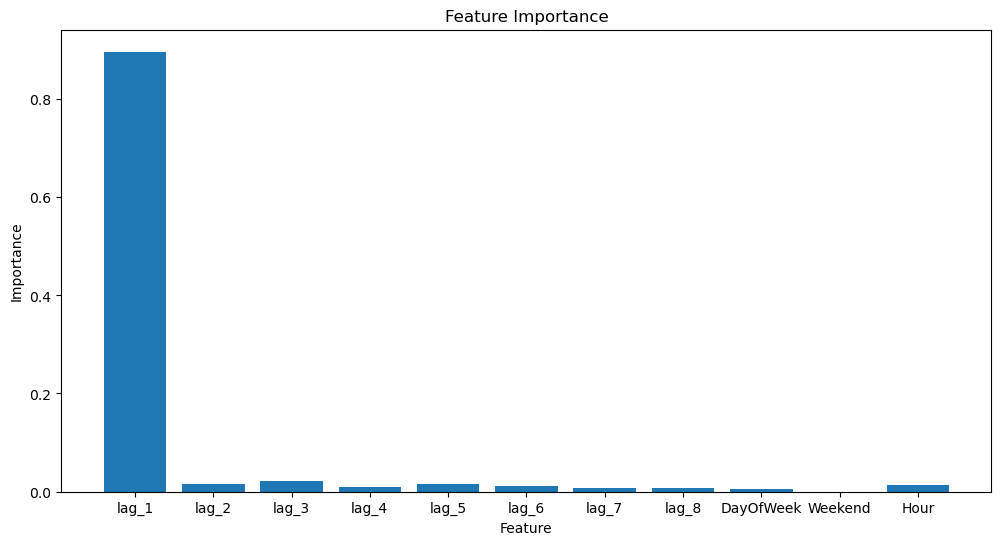

In [74]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[3:],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("images/porto_xgb_last2hours_feature_importance.png")
plt.show()

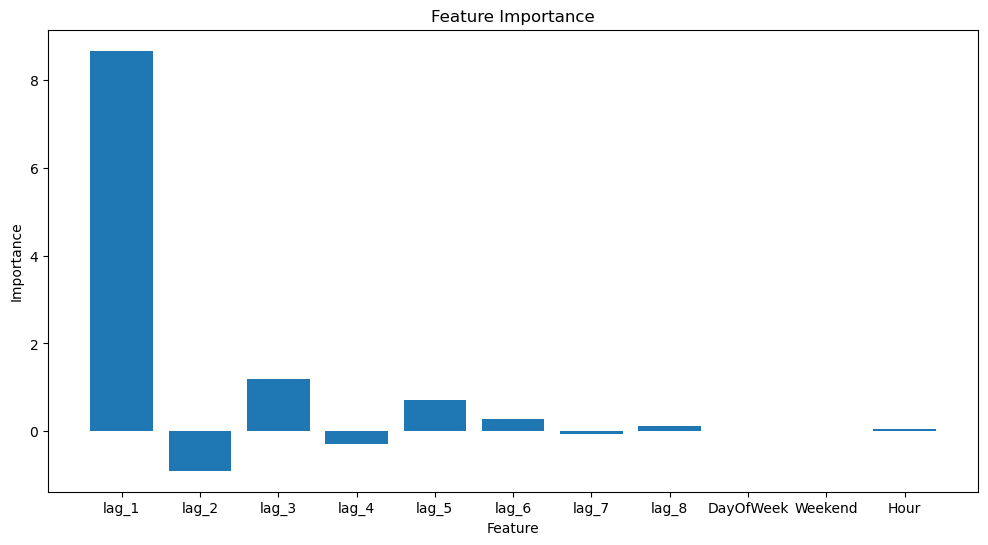

In [75]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[3:],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [76]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

lag_1        0.896702
lag_2        0.014464
lag_3        0.021644
lag_4        0.008382
lag_5        0.014518
lag_6        0.011371
lag_7        0.007478
lag_8        0.006907
DayOfWeek    0.005883
Weekend      0.000000
Hour         0.012651
dtype: float32

In [77]:
features = feature_importance.nlargest(40).index
features

Index(['lag_1', 'lag_3', 'lag_5', 'lag_2', 'Hour', 'lag_6', 'lag_4', 'lag_7',
       'lag_8', 'DayOfWeek', 'Weekend'],
      dtype='object')

In [ ]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

### Test with 40 best features

In [ ]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

In [ ]:
df_test = pd.read_csv("data/porto_best40features.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_40 = pd.read_csv("data/porto_best40features.csv", engine='c', dtype=float32_cols)
df_40

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [ ]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [ ]:
sourceFile.close()